In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice = Word('Alice', n)
experiences = Word('experiences', n.r @ s @ n.l)
adverse_event =  Word('an adverse event', n)
who = Word('who', n.r @ n @ s.l @ n)
has_green_feet = Word('has green feet', n.r @ s)

vocab = [Alice, has_green_feet, adverse_event, who, experiences]

In [2]:
from time import time
from discopy.grammar import brute_force

gen, n_sentences = brute_force(*vocab), 10
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("\n{:.2f} seconds to generate {} sentences.".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice has green feet.
an adverse event has green feet.
Alice experiences Alice.
Alice experiences an adverse event.
an adverse event experiences Alice.
an adverse event experiences an adverse event.
Alice who has green feet has green feet.
an adverse event who has green feet has green feet.
Alice who has green feet experiences Alice.
Alice who has green feet experiences an adverse event.

1.61 seconds to generate 10 sentences.


Diagram for 'Alice who has green feet experiences an adverse event.':


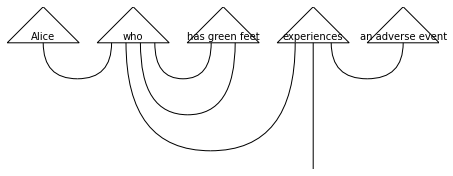

In [3]:
from discopy.grammar import draw
print("Diagram for 'Alice who has green feet experiences an adverse event.':")
draw(parsing['Alice who has green feet experiences an adverse event.'], draw_type_labels=False)

Circuit for the GHZ state, used as ansatz for "who":


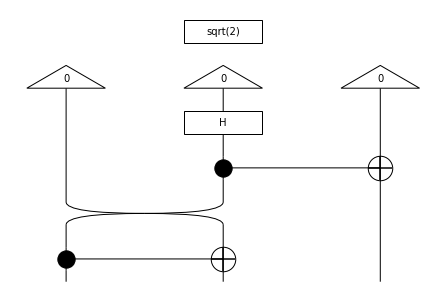

In [4]:
from discopy.quantum import Circuit, sqrt, Ket, H, Rx, CX, SWAP

# Ansatz for words with type `n`, e.g. 'Alice', 'adverse_event'
def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

# Ansatz for words with type `n.r @ s @ n.l`, e.g. 'loves'
def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

GHZ = sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)

print("Circuit for the GHZ state, used as ansatz for \"who\":")
GHZ.draw(aspect='auto', draw_type_labels=False)

Circuit for 'Alice who has green feet experiences an adverse event.':


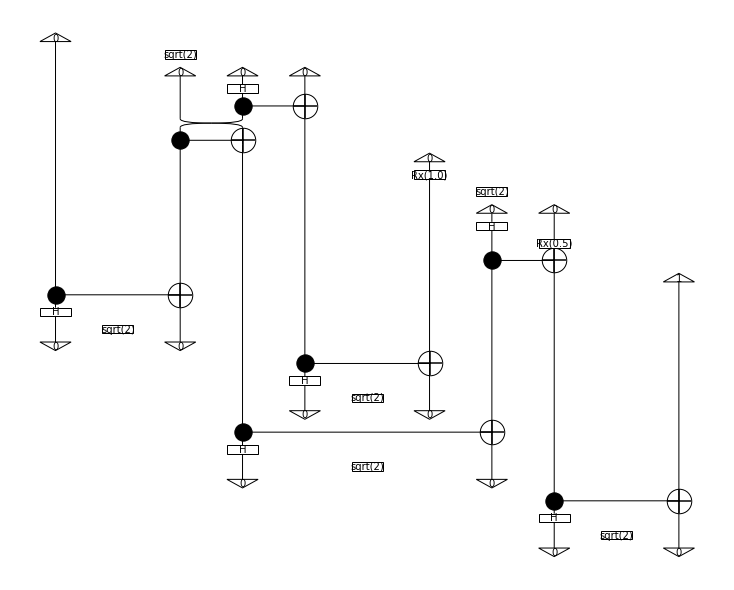

In [5]:
import numpy as np
from discopy import CircuitFunctor, qubit

F = lambda params: CircuitFunctor(
    ob={s: qubit ** 0, n: qubit ** 1},
    ar={Alice: Ket(0),
        experiences: transitive_ansatz(params[0]),
        adverse_event: Ket(1),
        who: GHZ,
        has_green_feet: intransitive_ansatz(params[1])})

params0 = np.array([0.5, 1.0])
print("Circuit for 'Alice who has green feet experiences an adverse event.':")
circuit = F(params0)(parsing['Alice who has green feet experiences an adverse event.'])
circuit.draw(figsize=(10, 8), aspect='auto', draw_type_labels=False)

In [6]:
from pytket.extensions.qiskit import tk_to_qiskit

tk_circ = circuit.to_tk()
print("{}:\n{}\n".format(tk_circ, '\n'.join(map(str, tk_circ))))
print("post selection:\n{}\n".format(tk_circ.post_selection))
print("scalar:\n{}\n".format(tk_circ.scalar))
print("qiskit circuit:")
tk_to_qiskit(tk_circ).draw()

<tket::Circuit, qubits=8, gates=24>:
H q[1];
Rx(2) q[4];
H q[5];
Rx(1) q[6];
X q[7];
CX q[1], q[3];
CX q[5], q[6];
CX q[1], q[2];
CX q[3], q[4];
CX q[6], q[7];
Measure q[4] --> c[3];
Measure q[7] --> c[7];
CX q[0], q[1];
CX q[2], q[5];
H q[3];
H q[6];
Measure q[1] --> c[1];
Measure q[3] --> c[2];
Measure q[5] --> c[5];
Measure q[6] --> c[6];
H q[0];
H q[2];
Measure q[0] --> c[0];
Measure q[2] --> c[4];

post selection:
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

scalar:
64.00000000000009

qiskit circuit:


┌───┐              ┌─┐   
q_0: ──────────────────────■──┤ H ├──────────────┤M├───
       ┌───┐             ┌─┴─┐└───┘┌─┐           └╥┘   
q_1: ──┤ H ├─────■────■──┤ X ├─────┤M├────────────╫────
       └───┘     │  ┌─┴─┐└───┘     └╥┘┌───┐       ║ ┌─┐
q_2: ────────────┼──┤ X ├───────■───╫─┤ H ├───────╫─┤M├
               ┌─┴─┐└───┘┌───┐  │   ║ └┬─┬┘       ║ └╥┘
q_3: ──────────┤ X ├──■──┤ H ├──┼───╫──┤M├────────╫──╫─
     ┌────────┐└───┘┌─┴─┐└┬─┬┘  │   ║  └╥┘        ║  ║ 
q_4: ┤ RX(2π) ├─────┤ X ├─┤M├───┼───╫───╫─────────╫──╫─
     └─┬───┬──┘     └───┘ └╥┘ ┌─┴─┐ ║   ║  ┌─┐    ║  ║ 
q_5: ──┤ H ├─────■─────────╫──┤ X ├─╫───╫──┤M├────╫──╫─
     ┌─┴───┴─┐ ┌─┴─┐       ║  ├───┤ ║   ║  └╥┘┌─┐ ║  ║ 
q_6: ┤ RX(π) ├─┤ X ├──■────╫──┤ H ├─╫───╫───╫─┤M├─╫──╫─
     └─┬───┬─┘ └───┘┌─┴─┐  ║  └┬─┬┘ ║   ║   ║ └╥┘ ║  ║ 
q_7: ──┤ X ├────────┤ X ├──╫───┤M├──╫───╫───╫──╫──╫──╫─
       └───┘        └───┘  ║   └╥┘  ║   ║   ║  ║  ║  ║ 
c: 8/══════════════════════╩════╩═══╩═══╩═══╩══╩══╩══╩═
                           3    7   1   2   5  6  0  4

In [7]:
def evaluate(params, sentences, backend, n_shots=2**10, seed=0):
    circuits = [F(params)(parsing[s]) for s in sentences]
    results = [Circuit.eval(
                circuit,
                backend=backend,
                n_shots=n_shots,
                seed=seed,
                compilation=backend.default_compilation_pass(2)) for circuit in circuits]
    tensors = [np.abs(result.array)[0] for result in results]
    return tensors

In [8]:
from pytket.extensions.qiskit import AerBackend

start = time()
corpus = dict(zip(sentences, evaluate(params0, sentences, backend=AerBackend())))
print(corpus)
print("{:.3f} seconds to compute the corpus.\n".format(time() - start))

delta = .01

print("True sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar > .5 + delta)))
print("False sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar < .5 - delta)))
print("Maybe sentences:\n{}".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if .5 - delta <= scalar <= .5 + delta)))

{'Alice has green feet.': 1.0351562500000002, 'an adverse event has green feet.': 0.0, 'Alice experiences Alice.': 0.0, 'Alice experiences an adverse event.': 1.1250000000000007, 'an adverse event experiences Alice.': 1.1250000000000007, 'an adverse event experiences an adverse event.': 0.0, 'Alice who has green feet has green feet.': 1.187500000000001, 'an adverse event who has green feet has green feet.': 0.0, 'Alice who has green feet experiences Alice.': 0.0, 'Alice who has green feet experiences an adverse event.': 1.0000000000000013}
0.299 seconds to compute the corpus.

True sentences:
Alice has green feet. (1.035)
Alice experiences an adverse event. (1.125)
an adverse event experiences Alice. (1.125)
Alice who has green feet has green feet. (1.188)
Alice who has green feet experiences an adverse event. (1.000)

False sentences:
an adverse event has green feet. (0.000)
Alice experiences Alice. (0.000)
an adverse event experiences an adverse event. (0.000)
an adverse event who ha

In [9]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.5, random_state=237)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(sentence_test)))

Training set:
Alice who has green feet has green feet.
an adverse event has green feet.
Alice has green feet.
Alice experiences an adverse event.
Alice experiences Alice.

Testing set:
an adverse event experiences an adverse event.
Alice who has green feet experiences Alice.
an adverse event experiences Alice.
Alice who has green feet experiences an adverse event.
an adverse event who has green feet has green feet.


In [10]:
def loss(params, sentences=sentence_train, backend=AerBackend()):
    return - np.mean(np.array([
        (corpus[sentence] - scalar) ** 2
        for sentence, scalar in zip(sentences, evaluate(params, sentences, backend))]))

In [11]:
backend=AerBackend()

from random import random, seed; seed(337)

params = np.array([random(), random()])

print("Random initialisation: {}".format(params))

print("\nExperiences Alice who has green feet an adverse event?")
print("Yes, she is."
      if evaluate(params, ['Alice who has green feet experiences an adverse event.'],backend)[0] > .5 + delta
      else "No, she isn't.")

Random initialisation: [0.2018591  0.83909858]

Experiences Alice who has green feet an adverse event?
No, she isn't.


In [12]:
import noisyopt

i, start = 0, time()

def callback(params):
    global i
    i += 1
    print("Epoch {} ({:.0f} seconds since start): {}".format(i, time() - start, params))

result = noisyopt.minimizeSPSA(
    loss, params, paired=False, callback=callback, niter=10, a=2)
result

Epoch 1 (0 seconds since start): [0.2018591  0.83909858]
Epoch 2 (0 seconds since start): [0.52668928 1.16392877]
Epoch 3 (1 seconds since start): [0.32965492 0.9668944 ]
Epoch 4 (1 seconds since start): [0.47379824 1.11103773]
Epoch 5 (1 seconds since start): [0.62504077 0.95979521]
Epoch 6 (1 seconds since start): [0.49577719 1.08905879]
Epoch 7 (1 seconds since start): [0.61477276 0.97006322]
Epoch 8 (2 seconds since start): [0.57156111 0.92685156]
Epoch 9 (2 seconds since start): [0.62617843 0.98146889]
Epoch 10 (2 seconds since start): [0.57089817 0.92618862]


     fun: -0.0069984436035156385
 message: 'terminated after reaching max number of iterations'
    nfev: 20
     nit: 10
 success: True
       x: array([0.57089817, 0.92618862])

In [13]:
print("Testing loss: {}".format(loss(result.x, sentences=sentence_test)))

Testing loss: -0.004406738281250014


In [14]:
print("Experiences Alice who has green feet an adverse event?")
print("Yes, she is."
      if evaluate(result.x, ['Alice who has green feet experiences an adverse event.'], backend=backend)[0] > .5 + delta
      else "No, she isn't.")

Experiences Alice who has green feet an adverse event?
Yes, she is.
